<div align="left">
<h4><a href="index.ipynb">RETURN TO INDEX</a></h4>
</div>
<div align="center">
<h1><a href="index.ipynb">DH3501: Advanced Social Networks</a><br/><br/><em>Class 15</em>: Graph Data Modeling and the Cypher Query Language </h1>
</div>

<div style="float:left">
<b>Western University</b><br/>
<b>Department of Modern Languages and Literatures</b><br/>
<b>Digital Humanities – DH 3501</b><br/>
<br/>
<b>Instructor</b>: David Brown<br/>
<b>E-mail</b>: <a href="mailto:dbrow52@uwo.ca">dbrow52@uwo.ca</a><br/>
<b>Office</b>: AHB 1R14<br/>
</div>
<div style="float:left">
<img style="width:200px; margin-left:100px" src="http://www.bsr.org/images/blog/networks.jpg" />
</div>

To begin, let's talk about the modeling the "email provenance modeling domain" discussed in chapter 3 of RWE.

What was the lesson taught here? 

What did then mean when they described the first model as lossy?

What was the final data model presented in the book? 

## Neo4j example

Today we are gonna skip the formalities and jump straight into using Neo4j.

Let's get started. **Fire up a terminal!** Then [download](http://info.neo4j.com/download-thanks.html?edition=community&flavour=unix&_ga=1.46919143.1349710317.1417922000), unpack, and start the neo4j server.

```bash
$ tar -xzvf neo4j-community-2.1.7-unix.tar.gz
$ mv neo4j-community-2.1.7 neo4j
$ cd neo4j
$ ./bin/neo4j console
```
Neo4j, like a relational database, provides a DSL that allows the users to execute queries against the data contained in the database. Neo4j provides an elegant, declarative language call Cypher. Cypher has its own syntax and semantics, but you can see how it is (in some ways) based on SQL.

For this class, we will be using the ipython-cypher package to execute Neo4j Cypher queries from the IPython environment. We'll also see how to use a Python client to connect to the database and execute Cypher.

In [1]:
# This sets up the "cell magic" used by ipython-cypher
%load_ext cypher
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%%cypher
// Cypher comments use two slashes
// A really useful query that clears the database
MATCH (n)
OPTIONAL MATCH (n)-[r]-()
DELETE n, r

21 relationship deleted.
17 nodes deleted.


[]

**NOTE** The following example, while taken from the book, is modified to use Neo4j labels.

Let's go throught the following Cypher CREATE statements, and then look at the domain(s) they are modeling.

In [3]:
%%cypher

CREATE
 (shakespeare:Person {firstname: 'William', lastname: 'Shakespeare'}),

 (juliusCaesar:Play {title: 'Julius Caesar'}),

 (shakespeare)-[:WROTE_PLAY {year: 1599}]->(juliusCaesar),

 (theTempest:Play { title: 'The Tempest' }),

 (shakespeare)-[:WROTE_PLAY { year: 1610}]->(theTempest),

 (rsc:Company {name: 'RSC'}),

 (production1:Production {name: 'Julius Caesar'}),

 (rsc)-[:PRODUCED]->(production1),

 (production1)-[:PRODUCTION_OF]->(juliusCaesar),

 (performance1:Date {date: 20120729}),

 (performance1)-[:PERFORMANCE_OF]->(production1),

 (production2:Production {name: 'The Tempest'}),

 (rsc)-[:PRODUCED]->(production2),

 (production2)-[:PRODUCTION_OF]->(theTempest),

 (performance2:Performance {date: 20061121}),

 (performance2)-[:PERFORMANCE_OF]->(production2),

 (performance3:Performance {date: 20120730}),

 (performance3)-[:PERFORMANCE_OF]->(production1),

 (billy:Person {name: 'Billy'}),

 (review:Review {rating: 5, review: 'This was awesome!'}),

 (billy)-[:WROTE_REVIEW]->(review),

 (review)-[:RATED]->(performance1),

 (theatreRoyal:Theatre {name: 'Theatre Royal'}),

 (performance1)-[:VENUE]->(theatreRoyal),

 (performance2)-[:VENUE]->(theatreRoyal),

 (performance3)-[:VENUE]->(theatreRoyal),

 (greyStreet:Street {name: 'Grey Street'}),

 (theatreRoyal)-[:STREET]->(greyStreet),

 (newcastle:City {name: 'Newcastle'}),

 (greyStreet)-[:CITY]->(newcastle),

 (tyneAndWear:County {name: 'Tyne and Wear'}),

 (newcastle)-[:COUNTY]->(tyneAndWear),

 (england:Country {name: 'England'}),

 (tyneAndWear)-[:COUNTRY]->(england),

 (stratford:City {name: 'Stratford upon Avon'}),

 (stratford)-[:COUNTRY]->(england),

 (rsc)-[:BASED_IN]->(stratford),

 (shakespeare)-[:BORN_IN]->stratford

17 labels added.
17 nodes created.
21 properties set.
21 relationships created.


[]

<img style="float:left; width: 500px" src="img/shakes.png">

To read data from the database, we use the `MATCH` keyword.

In [4]:
# This query returns all edges in the graph.
results = %cypher MATCH (n)-[e]->(m) RETURN n, e, m

21 rows affected.


## How good are you at drawing in NetworkX? Let's take a quick side trip and look at some more advanced drawing with NetworkX:

In [5]:
# Some simple drawing functions.
def draw_simple_graph(graph, node_type_attr='type',
                      edge_label_attr='weight', show_edge_labels=True,
                      label_attrs=['label']):
    """
    Utility function to draw a labeled, colored graph with Matplotlib.
    :param graph: networkx.Graph
    """
    lbls = labels(graph, label_attrs=label_attrs)
    clrs = colors(graph, node_type_attr=node_type_attr)
    pos = nx.spring_layout(graph)
    if show_edge_labels:
        e_labels = edge_labels(graph, edge_label_attr=edge_label_attr)
    else:
        e_labels = {}
    nx.draw_networkx(graph, pos=pos, node_color=clrs)
    nx.draw_networkx_labels(graph, pos=pos, labels=lbls)
    
def labels(graph, label_attrs=['label']):
    """
    Utility function that aggreates node attributes as
    labels for drawing graph in Ipython Notebook.
    :param graph: networkx.Graph
    :returns: Dict. Nodes as keys, labels as values.
    """
    labels_dict = {}
    for node, attrs in graph.nodes(data=True):
        label = u''
        for k, v in attrs.items():
            if k in label_attrs:
                try:
                    label += u'{0}: {1}\n'.format(k, v)
                except:
                    label += u'{0}: {1}\n'.format(k, v).encode('utf-8')
        labels_dict[node] = label
    return labels_dict

def edge_labels(graph, edge_label_attr='weight'):
    """
    Utility function that aggreates node attributes as
    labels for drawing graph in Ipython Notebook.
    :param graph: networkx.Graph
    :returns: Dict. Nodes as keys, labels as values.
    """
    labels_dict = {}
    for i, j, attrs in graph.edges(data=True):
        label = attrs.get(edge_label_attr, '')
        labels_dict[(i, j)] = label
    return labels_dict
def edge_labels(graph, edge_label_attr='weight'):
    """
    Utility function that aggreates node attributes as
    labels for drawing graph in Ipython Notebook.
    :param graph: networkx.Graph
    :returns: Dict. Nodes as keys, labels as values.
    """
    labels_dict = {}
    for i, j, attrs in graph.edges(data=True):
        label = attrs.get(edge_label_attr, '')
        labels_dict[(i, j)] = label
    return labels_dict


def colors(graph, node_type_attr='type'):
    """
    Utility function that generates colors for node
    types for drawing graph in Ipython Notebook.
    :param graph: networkx.Graph
    :returns: Dict. Nodes as keys, colors as values.
    """
    colors_dict = {}
    colors = []
    counter = 1
    for node, attrs in graph.nodes(data=True):
        if attrs.get(node_type_attr, "")[0] not in colors_dict:
            colors_dict[attrs[node_type_attr][0]] = float(counter)
            colors.append(float(counter))
            counter += 1
        else:
            colors.append(colors_dict[attrs[node_type_attr][0]])
    return colors

def colors(graph, node_type_attr='type'):
    """
    Utility function that generates colors for node
    types for drawing graph in Ipython Notebook.
    :param graph: networkx.Graph
    :returns: Dict. Nodes as keys, colors as values.
    """
    colors_dict = {}
    colors = []
    counter = 1
    for node, attrs in graph.nodes(data=True):
        if attrs.get(node_type_attr, "")[0] not in colors_dict:
            colors_dict[attrs.get(node_type_attr, "")[0]] = float(counter)
            colors.append(float(counter))
            counter += 1
        else:
            colors.append(colors_dict[attrs.get(node_type_attr, "")[0]])
    return colors

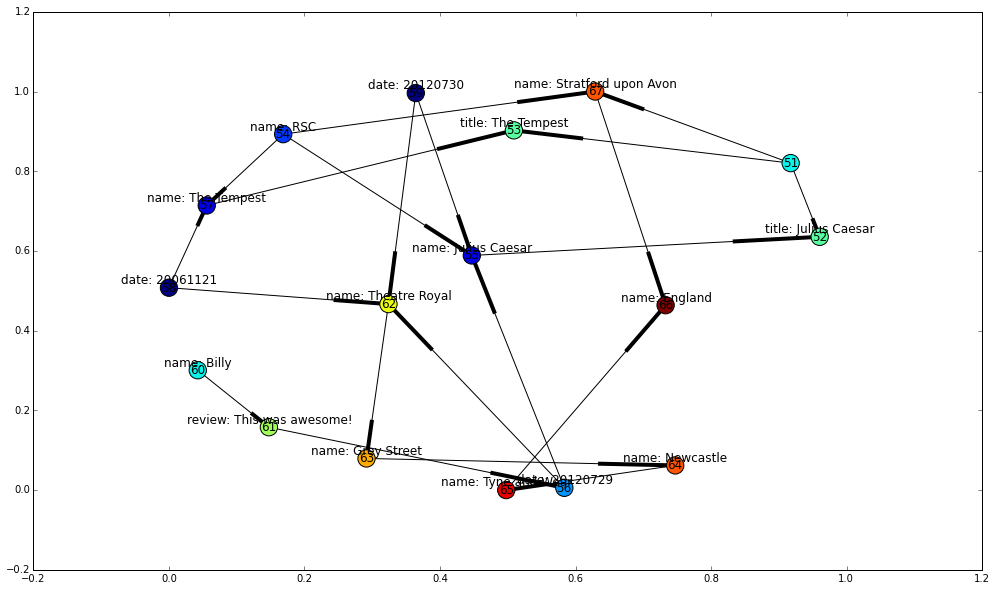

In [6]:
plt.rcParams["figure.figsize"] = 17, 10
g = results.get_graph()
draw_simple_graph(g, node_type_attr="labels", label_attrs=["name", "title", "date", "review"])

####Let's talk about the above data model, according to the book, it incorporates three domains. What are these domains? Is this an advantage? How would this be usefull in the humanities?

## Let's look at some queries in Cypher

The book shows us an **old form of Cypher**, but it illustrates some interesting concepts. Let's look at the following query piece by piece, then we will translate it to modern Cypher.

In [7]:
%%cypher
START theater=node:venue(name='Theatre Royal'),
      newcastle=node:city(name='Newcastle'),
      bard=node:author(lastname='Shakespeare')

MATCH (newcastle)<-[:STREET|CITY*1..2]-(theater)
      <-[:VENUE]-()-[:PERFORMANCE_OF]->()-[:PRODUCTION_OF]->
      (play)<-[:WROTE_PLAY]-(bard)

RETURN DISTINCT play.title AS play

Code [200]: OK. Request fulfilled, document follows.

Neo.ClientError.Schema.NoSuchIndex:
Index `author` does not exist



In [8]:
%%cypher

MATCH (newcastle:City {name:"Newcastle"})<-[:STREET|CITY*1..2]-(theatre:Theatre {name: "Theatre Royal"})

<-[:VENUE]-()-[:PERFORMANCE_OF]->()-[:PRODUCTION_OF]->

(play)<-[:WROTE_PLAY]-(bard:Person {lastname: 'Shakespeare'})

RETURN DISTINCT play.title AS play

2 rows affected.


play
Julius Caesar
The Tempest


## More examples???

#### Let's take a detailed look at the [refcard](http://neo4j.com/docs/stable/cypher-refcard/) and [docs](http://neo4j.com/developer/cypher-query-language/).

## Challenge: Writing read queries in Cypher

* At your pod, come up with two or three questions about the Shakepeare dataset. You can pretend that there is more data...

* Then, for each question, write a query that answers the question.

In [9]:
%%cypher
// Write your queries here

Code [500]: Internal Server Error. Server got itself in trouble.
Element not found
